In [13]:
import os
import random, math
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch_geometric.nn import GCNConv
from torch_geometric_temporal.nn.recurrent import TGCN, EvolveGCNH, A3TGCN
from torch_geometric.utils import dropout_edge
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning import Trainer
from torch.utils.data import DataLoader, TensorDataset, Sampler
from collections import defaultdict

# Set environment variables for reproducibility and safety
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import precision_score, recall_score, accuracy_score

# 1. Configuration & Seeding
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

## 1. Creating Temporal Features

In [14]:
name = 'movie'

interaction_df = pd.read_csv(f'./data/{name}/{name}_processed_interactions.csv')
interaction_df['timestamp'] = pd.to_datetime(interaction_df['timestamp'])
interaction_df = interaction_df.sort_values(by='timestamp').reset_index(drop=True)

interaction_df['year'] = interaction_df['timestamp'].dt.year
interaction_df['month'] = interaction_df['timestamp'].dt.month
interaction_df['week'] = interaction_df['timestamp'].dt.isocalendar().week
# Simple season mapping (1:Winter, 2:Spring, 3:Summer, 4:Fall)
interaction_df['season'] = interaction_df['month'].apply(lambda x: (x%12 + 3)//3)

### 1.1 Creating Temporal Statistical Features

In [15]:
# A. Handle Cyclical Features (Month, Week, Season)
# We transform "Month" into two dimensions: sin_month and cos_month.
# This places months on a unit circle.
def encode_cyclic(data, max_val):
    data_norm = 2 * np.pi * data / max_val
    return np.sin(data_norm), np.cos(data_norm)

In [16]:
interaction_df['month_sin'], interaction_df['month_cos'] = encode_cyclic(interaction_df['month'], 12)
interaction_df['week_sin'], interaction_df['week_cos'] = encode_cyclic(interaction_df['week'], 52)
interaction_df['season_sin'], interaction_df['season_cos'] = encode_cyclic(interaction_df['season'], 4)

feature_cols = [
    'season_sin', 'season_cos',
    'month_sin', 'month_cos', 
    'week_sin', 'week_cos',
]

f_stat = interaction_df[['timestamp'] + feature_cols] # dataframe
f_stat = f_stat.drop_duplicates()
print(f_stat.tail(5))

print(f"\nFeature Matrix Shape: {f_stat.shape}")    # Feature Matrix Shape: (5919, 7)

       timestamp    season_sin    season_cos  month_sin     month_cos  \
61085 2017-11-30 -2.449294e-16  1.000000e+00  -0.500000  8.660254e-01   
61086 2018-01-04  1.000000e+00  6.123234e-17   0.500000  8.660254e-01   
61087 2018-02-19  1.000000e+00  6.123234e-17   0.866025  5.000000e-01   
61088 2018-03-10  1.224647e-16 -1.000000e+00   1.000000  6.123234e-17   
61089 2018-04-26  1.224647e-16 -1.000000e+00   0.866025 -5.000000e-01   

       week_sin  week_cos  
61085 -0.464723  0.885456  
61086  0.120537  0.992709  
61087  0.822984  0.568065  
61088  0.935016  0.354605  
61089  0.885456 -0.464723  

Feature Matrix Shape: (5231, 7)


### 1.2 Creating Temporal Structure Features

In [17]:
def calculate_structural_features(df, interaction_count_col='interaction_count', 
                                gaps=[90, 30, 7, 1]):
    """
    Calculates 1st and 2nd order structural features (z' and z'') for specified gaps.
    
    Parameters:
    - df: DataFrame containing time-series data.
    - interaction_count_col: Name of the column containing interaction counts (z(i)).
    - gaps: List of window sizes (default: [90, 30, 7, 1] for season, month, week, day).
    
    Returns:
    - DataFrame with new columns for each gap (z_prime and z_double_prime).
    """
    
    # We work on a copy to avoid Modifying the original dataframe
    result_df = df.copy()
    result_df = result_df.sort_values(by='timestamp').reset_index(drop=True)
    
    # Extract the base interaction series z(i)
    z = result_df[interaction_count_col]
    
    feature_list = []
    
    for gap in gaps:
        # --- 1. First-Order Structural Feature: z'_{gap}(t) ---
        # Formula: (Sum(current_window) - Sum(previous_window)) / gap
        
        # Calculate rolling sum for the current window [t-gap, t]
        # This corresponds to Sum_{i=t-gap}^{t} z(i)
        current_sum = z.rolling(window=gap, min_periods=gap).sum()
        
        # The previous window sum is just the current sum shifted by 'gap'
        # This corresponds to Sum_{i=t-2gap}^{t-gap} z(i)
        prev_sum = current_sum.shift(gap)
        
        # Calculate z'
        z_prime = (current_sum - prev_sum) / gap
        
        # Rename for storage
        z_prime_col_name = f'z_prime_{gap}'
        result_df[z_prime_col_name] = z_prime
        
        # --- 2. Second-Order Structural Feature: z''_{gap}(t) ---
        # Formula: (Sum(current_window_of_z') - Sum(previous_window_of_z')) / gap
        
        # Now we apply the same rolling logic to the z_prime series we just created
        current_sum_prime = z_prime.rolling(window=gap, min_periods=gap).sum()
        prev_sum_prime = current_sum_prime.shift(gap)
        
        # Calculate z''
        z_double_prime = (current_sum_prime - prev_sum_prime) / gap
        
        # Rename for storage
        z_double_prime_col_name = f'z_double_prime_{gap}'
        result_df[z_double_prime_col_name] = z_double_prime
        
        # --- 3. Padding (Handling Initial NaNs) ---
        # The paper states: "padding... with the nearest timestamp's temporal structural feature"
        # Because we used rolling windows, the beginning of the series will have NaNs.
        # We use backfill (bfill) to propagate the first valid observation backwards.
        result_df[z_prime_col_name] = result_df[z_prime_col_name].bfill()
        result_df[z_double_prime_col_name] = result_df[z_double_prime_col_name].bfill()
        
        # Keep track of feature names for the final concatenation
        feature_list.extend([z_prime_col_name, z_double_prime_col_name])

    # Return only the extracted features (concatenated as per Eq 2)
    return result_df[['timestamp'] + feature_list]

In [18]:
daily_interaction_count_df = interaction_df.groupby('timestamp').size().reset_index(name='interaction_count')
daily_interaction_count_df = daily_interaction_count_df.sort_values(by='timestamp').reset_index(drop=True)
print(daily_interaction_count_df.head(1))

# Extract Features
f_stru = calculate_structural_features(daily_interaction_count_df, 
                                        gaps=[90, 30, 7, 1])    #dataframe

# Check shape (Should have 9 columns: 1 for timestamp and 2 for each of the 4 gaps)
print(f"\nFeature Matrix Shape: {f_stru.shape}")    #Feature Matrix Shape: (5919, 9)

# Display Result
print("Input Data (Tail):")
print(f_stru.tail(5))
print("\nExtracted Structural Features (Tail):")
print(f_stru.tail(5))


   timestamp  interaction_count
0 1999-04-10                  1

Feature Matrix Shape: (5231, 9)
Input Data (Tail):
      timestamp  z_prime_90  z_double_prime_90  z_prime_30  z_double_prime_30  \
5226 2017-11-30  -22.933333          -9.622099    0.300000          14.780000   
5227 2018-01-04  -22.855556          -9.729136    0.300000          14.128889   
5228 2018-02-19  -22.755556          -9.836296    0.300000          13.475556   
5229 2018-03-10  -22.888889          -9.936667    0.300000          12.760000   
5230 2018-04-26  -22.600000         -10.028765    0.333333          12.045556   

      z_prime_7  z_double_prime_7  z_prime_1  z_double_prime_1  
5226   0.142857         -0.265306        0.0               3.0  
5227   0.285714          0.000000        0.0               0.0  
5228   0.285714          0.183673        0.0               0.0  
5229   0.285714          0.285714        0.0               0.0  
5230   0.285714          0.408163        0.0               0.0  

Extrac

### 1.3 Concat Temporal Statistical Features and Temporal Structure Features

In [19]:
f_all = pd.merge(f_stat, f_stru, on='timestamp', how='inner')
print(f_all.tail(1))
print(f'f_stat.shape: {f_stat.shape}')
print(f'f_stru.shape: {f_stru.shape}')
print(f'f_all.shape: {f_all.shape}')


      timestamp    season_sin  season_cos  month_sin  month_cos  week_sin  \
5230 2018-04-26  1.224647e-16        -1.0   0.866025       -0.5  0.885456   

      week_cos  z_prime_90  z_double_prime_90  z_prime_30  z_double_prime_30  \
5230 -0.464723       -22.6         -10.028765    0.333333          12.045556   

      z_prime_7  z_double_prime_7  z_prime_1  z_double_prime_1  
5230   0.285714          0.408163        0.0               0.0  
f_stat.shape: (5231, 7)
f_stru.shape: (5231, 9)
f_all.shape: (5231, 15)


Clustering

In [23]:
# # Apply K-Means
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)

f_all_feature_only = f_all.drop('timestamp', axis=1)
f_all['cluster_label'] = kmeans.fit_predict(f_all_feature_only)

print(f_all.tail(1))

print(f'f_all.shape: {f_all.shape}')


      timestamp    season_sin  season_cos  month_sin  month_cos  week_sin  \
5230 2018-04-26  1.224647e-16        -1.0   0.866025       -0.5  0.885456   

      week_cos  z_prime_90  z_double_prime_90  z_prime_30  z_double_prime_30  \
5230 -0.464723       -22.6         -10.028765    0.333333          12.045556   

      z_prime_7  z_double_prime_7  z_prime_1  z_double_prime_1  cluster_label  
5230   0.285714          0.408163        0.0               0.0              1  
f_all.shape: (5231, 16)


temporal_interaction_df.shape: (61090, 32)
temporal_interaction_df.columns: Index(['user_id', 'entity_id', 'timestamp', 'user_id:token', 'entity_id:token',
       'item_id:token', 'rating:float', 'year', 'month', 'week', 'season',
       'month_sin_x', 'month_cos_x', 'week_sin_x', 'week_cos_x',
       'season_sin_x', 'season_cos_x', 'season_sin_y', 'season_cos_y',
       'month_sin_y', 'month_cos_y', 'week_sin_y', 'week_cos_y', 'z_prime_90',
       'z_double_prime_90', 'z_prime_30', 'z_double_prime_30', 'z_prime_7',
       'z_double_prime_7', 'z_prime_1', 'z_double_prime_1', 'cluster_label'],
      dtype='object')
       user_id  entity_id  timestamp   user_id:token entity_id:token  \
61089     5432      21494 2018-04-26  A3NQU1649SH0Q4   res:Alpha_Dog   

      item_id:token  rating:float  year  month  week  ...  week_cos_y  \
61089    B00005JPK3           1.0  2018      4    17  ...   -0.464723   

       z_prime_90  z_double_prime_90  z_prime_30  z_double_prime_30  \
61089       -22

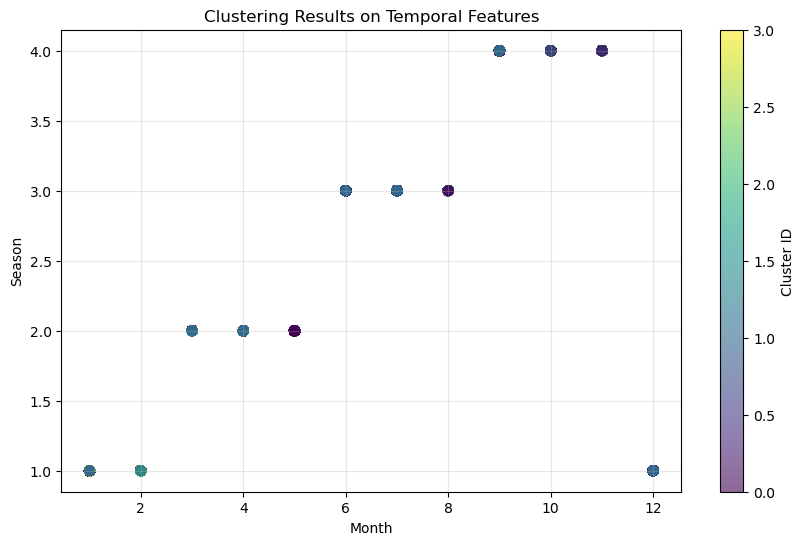

In [25]:
temporal_interaction_df = pd.merge(interaction_df, f_all, on='timestamp', how='inner')
print(f'temporal_interaction_df.shape: {temporal_interaction_df.shape}')
print(f'temporal_interaction_df.columns: {temporal_interaction_df.columns}')
print(temporal_interaction_df.tail(1))

# ---------------------------------------------------------
# 5. Visualizing the clusters (using just Month vs Year for simplicity)
# ---------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.scatter(temporal_interaction_df['month'], temporal_interaction_df['season'], c=temporal_interaction_df['cluster_label'], cmap='viridis', s=50, alpha=0.6)
plt.xlabel('Month')
plt.ylabel('Season')
plt.title('Clustering Results on Temporal Features')
plt.colorbar(label='Cluster ID')
plt.grid(True, alpha=0.3)
plt.show()

temporal_interaction_df.to_csv(f'./data/{name}/{name}_temporal_interactions.csv', index=False)
